<a href="https://colab.research.google.com/github/SurajNatekar28/SNA_assignments/blob/main/sna_assign2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PART A**

**1.shallow embeddings**

In [ ]:
!pip install node2vec

**Download and extract dataset**

Extracted files: ['fb-pages-politician.edges', 'readme.html', 'fb-pages-politician.nodes']


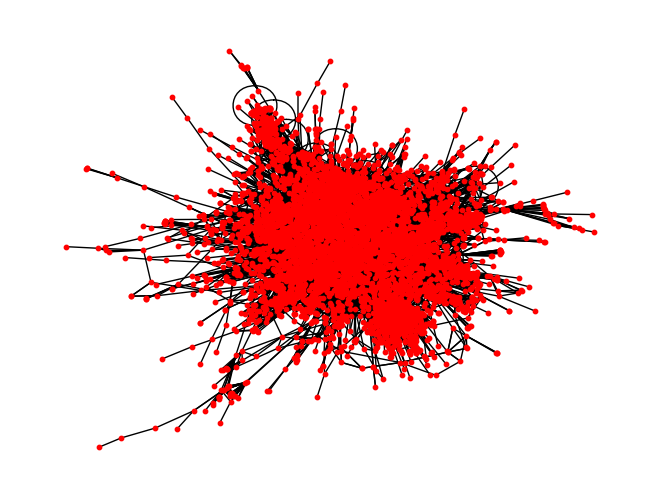

Graph with 5908 nodes and 41729 edges


In [ ]:
import requests, zipfile, io
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from node2vec import Node2Vec

r = requests.get('https://nrvis.com/download/data/soc/fb-pages-politician.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
extracted_files = z.namelist()
print("Extracted files:", extracted_files)

csv_file_path = extracted_files[0]
with open(csv_file_path, 'r') as f:
    df = pd.read_csv(f, sep=None, header=None, engine='python')
df.columns = ['source', 'target']

G = nx.Graph()
for index, row in df.iterrows():
    G.add_edge(row['source'], row['target'])

nx.draw(G, node_color='red', edge_color='black', node_size=10)
plt.show()
print(G)



**Initialize node2vec model**

In [ ]:

node2vec = Node2Vec(G, dimensions=32, walk_length=10, num_walks=20, workers=4)

model = node2vec.fit(window=5, min_count=1, batch_words=4)

node_embeddings = {str(node): model.wv[str(node)] for node in G.nodes()}
# Convert embeddings to a matrix
embedding_matrix = np.array([node_embeddings[str(node)] for node in G.nodes()])
print(embedding_matrix)

Computing transition probabilities:   0%|          | 0/5908 [00:00<?, ?it/s]

[[ 1.2342049  -0.96054703  0.17534997 ... -0.11112757  0.49764854
   0.9715493 ]
 [ 1.3773537  -0.6816878   0.44527867 ... -0.16464284  0.29281834
   0.85703295]
 [ 1.6102402  -1.1753327  -0.04778669 ...  0.07457898  0.59029514
   0.9008864 ]
 ...
 [ 0.50188863 -0.36269858 -0.00918548 ...  0.08144029  0.52271515
   0.9749655 ]
 [ 0.07892255 -0.5728487   0.4695778  ... -0.3792417   1.0355479
   0.81182957]
 [ 0.11112446 -0.42387035  0.11576775 ...  0.22805181 -0.52473813
   0.04860136]]


**tsne visulisation**

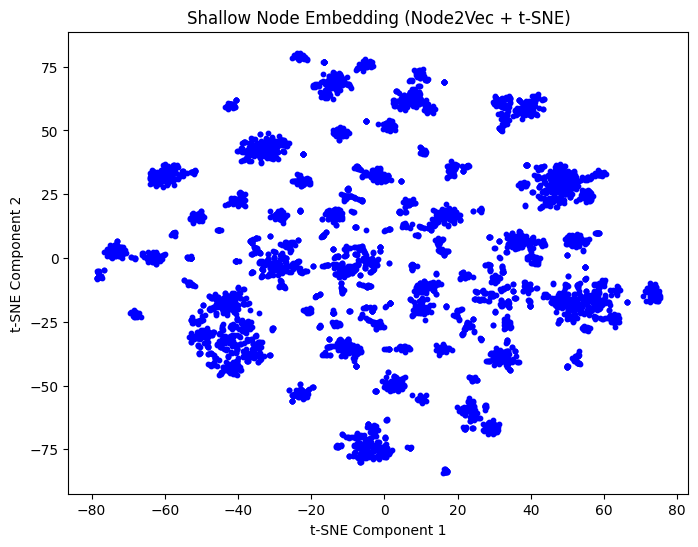

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
reduced_embeddings_tsne = tsne.fit_transform(embedding_matrix)
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c='blue', s=10)
plt.title('Shallow Node Embedding (Node2Vec + t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


**2.Deep Node embeddings**

In [ ]:
!pip install torch_geometric
import torch
import pandas as pd
import networkx as nx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.5 MB/s eta 0:00:00


In [ ]:
# Step 2: Convert the graph to PyTorch Geometric format
data = from_networkx(G)

num_node_features = 32
data.x = torch.rand((data.num_nodes, num_node_features))

num_classes = 32

**Defining and training GCN model**

In [ ]:
import torch.nn as nn
data.y=torch.tensor(embedding_matrix,dtype=torch.float32)
print(data.y)

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features,64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 64)
        self.conv4 = GCNConv(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x = self.conv4(x, edge_index)
        return x

# Initialize the GCN model
hidden_channels = 64
model = GCN(num_node_features, hidden_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion1 = nn.MSELoss()

def train(model, data, optimizer, criterion, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion1(out, data.y)
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

train(model, data, optimizer, criterion1)

model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.y, data.edge_index)
    print("Node embeddings shape:", embeddings.shape)

tensor([[ 1.2342, -0.9605,  0.1753,  ..., -0.1111,  0.4976,  0.9715],
        [ 1.3774, -0.6817,  0.4453,  ..., -0.1646,  0.2928,  0.8570],
        [ 1.6102, -1.1753, -0.0478,  ...,  0.0746,  0.5903,  0.9009],
        ...,
        [ 0.5019, -0.3627, -0.0092,  ...,  0.0814,  0.5227,  0.9750],
        [ 0.0789, -0.5728,  0.4696,  ..., -0.3792,  1.0355,  0.8118],
        [ 0.1111, -0.4239,  0.1158,  ...,  0.2281, -0.5247,  0.0486]])
Epoch 0, Loss: 0.4969
Epoch 50, Loss: 0.3113
Epoch 100, Loss: 0.3062
Epoch 150, Loss: 0.3042
Node embeddings shape: torch.Size([5908, 64])


**tsne visualisation**

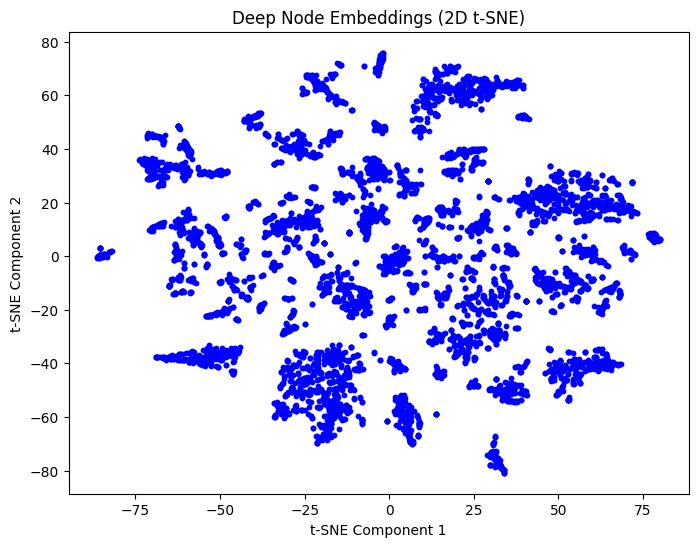

In [ ]:
tsne = TSNE(n_components=2)
reduced_embeddings_tsne = tsne.fit_transform(embeddings.numpy())

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c='blue', s=10)
plt.title('Deep Node Embeddings (2D t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

**PART B**

**Cora citation Network**

In [ ]:
!pip install torch_geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score

# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

Processing...
Done!


In [ ]:
num_nodes = data.num_nodes

indices = torch.randperm(num_nodes)

train_size = int(0.25 * num_nodes)
#test_size = num_nodes - train_size
train_indices = indices[:train_size]
test_indices = indices[train_size:train_size+1000]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
test_mask[test_indices] = True

data.train_mask = train_mask
data.test_mask = test_mask

**GCN model**

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
in_channels = dataset.num_node_features
hidden_channels = 16
out_channels = dataset.num_classes
num_epochs = 150
lr = 0.01
weight_decay = 5e-4

# model
model = GCN(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
data = data.to(device)

**Training Model**

In [ ]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    print("train",data.train_mask.sum())
    loss.backward()
    optimizer.step()

    print("test",data.test_mask.sum())
    with torch.no_grad():
        pred = out.argmax(dim=1)
        train_accuracy = accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu())

        val_accuracy = accuracy_score(data.y[data.val_mask].cpu(), pred[data.val_mask].cpu())

        test_accuracy = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())

    # Print loss, training accuracy, and test accuracy
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')


train tensor(677)
test tensor(1000)
Epoch 1/150, Loss: 0.0421, Train Accuracy: 0.9956, Test Accuracy: 0.8350
train tensor(677)
test tensor(1000)
Epoch 2/150, Loss: 0.0499, Train Accuracy: 0.9897, Test Accuracy: 0.8370
train tensor(677)
test tensor(1000)
Epoch 3/150, Loss: 0.0480, Train Accuracy: 0.9941, Test Accuracy: 0.8380
train tensor(677)
test tensor(1000)
Epoch 4/150, Loss: 0.0513, Train Accuracy: 0.9926, Test Accuracy: 0.8320
train tensor(677)
test tensor(1000)
Epoch 5/150, Loss: 0.0487, Train Accuracy: 0.9926, Test Accuracy: 0.8300
train tensor(677)
test tensor(1000)
Epoch 6/150, Loss: 0.0481, Train Accuracy: 0.9911, Test Accuracy: 0.8250
train tensor(677)
test tensor(1000)
Epoch 7/150, Loss: 0.0514, Train Accuracy: 0.9897, Test Accuracy: 0.8440
train tensor(677)
test tensor(1000)
Epoch 8/150, Loss: 0.0522, Train Accuracy: 0.9867, Test Accuracy: 0.8290
train tensor(677)
test tensor(1000)
Epoch 9/150, Loss: 0.0495, Train Accuracy: 0.9926, Test Accuracy: 0.8420
train tensor(677)
t

In [ ]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

#print final test accuracy
final_test_accuracy = accuracy_score(pred[data.test_mask].cpu(), data.y[data.test_mask].cpu())
print(f'Final Test Accuracy: {final_test_accuracy:.4f}')

Final Test Accuracy: 0.8560


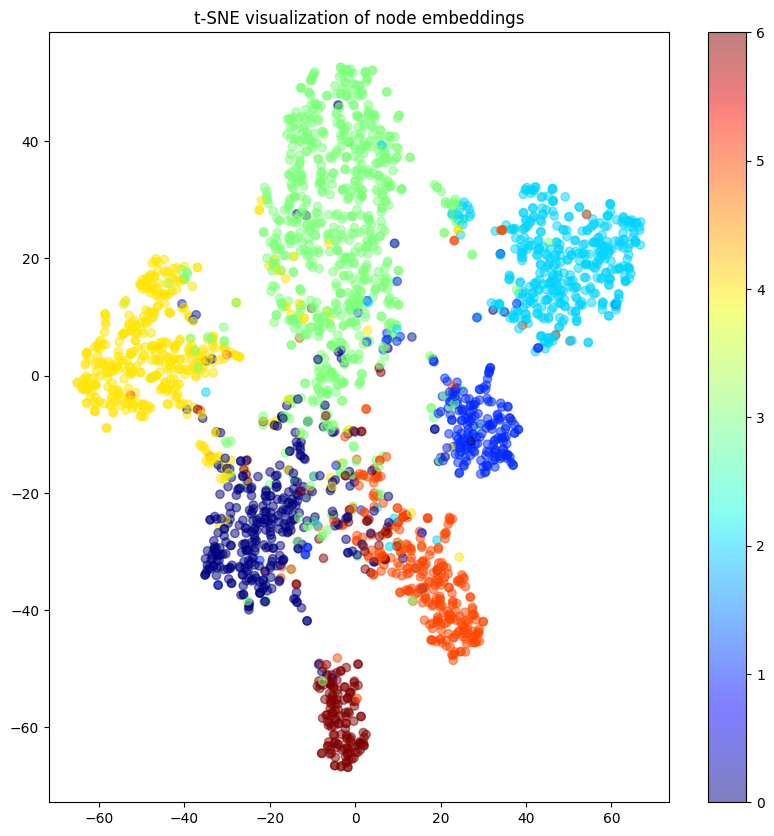

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

with torch.no_grad():
    embeddings = model.conv2(model.conv1(data.x, data.edge_index), data.edge_index).cpu().numpy()
    labels = data.y.cpu().numpy()

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='jet', alpha=0.5)
plt.title('t-SNE visualization of node embeddings')
plt.colorbar(scatter)
plt.show()
